In [57]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import hamming, medfilt

In [58]:
def define_energy(signal: np.ndarray, frame_length, hop_length) -> np.ndarray:
    energy = np.array([
        np.sum(np.abs(signal[i:i+frame_length])**2)
        for i in range(0, len(signal), hop_length)
    ])  
    return energy

def find_voice_index(signal: np.ndarray, frame_length, hop_length, thresh=0.05) -> list:
    index_voices = []

    # Tính energy
    energy = define_energy(signal, frame_length, hop_length)

    energy_norm = energy / max(energy)

    # Tạo danh sách các frame index mà energy >= ngưỡng
    for i in range(len(energy)):
        if energy_norm[i] >= thresh:
            index_voices.append(i)

    return index_voices

In [59]:
# Hàm tìm F0 bằng phương pháp HPS
def find_f0(signal, sample_rate, min_freq=60, max_freq=400):
    # Áp dụng cửa sổ Hamming để làm mượt tín hiệu
    windowed_signal = signal * np.hamming(len(signal))
    
    # Thực hiện FFT và chỉ lấy phổ biên độ
    spectrum = np.abs(fft(windowed_signal))
    
    # Chỉ cần lấy nửa đầu của phổ (dải tần từ 0 đến Nyquist)
    spectrum = spectrum[:len(spectrum)//2]
    freqs = np.fft.fftfreq(len(signal), 1/sample_rate)[:len(spectrum)]
    
    # # Giới hạn tần số trong dải quan tâm (80Hz - 400Hz)
    # valid_freqs = (freqs >= min_freq) & (freqs <= max_freq)
    # freqs = freqs[valid_freqs]
    # spectrum = spectrum[valid_freqs]
    
    # Áp dụng HPS (Harmonic Product Spectrum)
    hps_spectrum = np.copy(spectrum)

    # Nhân phổ với các bội số 2, 3, 4
    for h in range(2, 5):
        downsampled_spectrum = spectrum[::h]
        hps_spectrum[:len(downsampled_spectrum)] *= downsampled_spectrum

    # Tìm tần số có biên độ lớn nhất sau khi áp dụng HPS
    peak_freq = freqs[np.argmax(hps_spectrum)]
    # print(peak_freq)
    return peak_freq


In [60]:
# Hàm tính F0 cho từng frame dựa trên các index_voices
def calculate_f0_per_frame(x, index_voices, frame_length, hop_length, sr, kernel_size=5):
    f0_values = []
    time_values = []

    for idx in index_voices:
        start = idx * hop_length
        end = start + frame_length
        frame = x[start:end]

        if len(frame) == frame_length:
            frame = frame * np.hamming(frame_length)
              # Áp dụng bộ lọc trung vị
            filtered_frame = medfilt(frame, kernel_size=kernel_size)
            f0 = find_f0(filtered_frame, sr)
            f0_values.append(f0 if f0 != 0 else np.nan)
            time_values.append(librosa.frames_to_time(idx, sr=sr, hop_length=hop_length))

    return time_values, f0_values


In [61]:
def find_f0s(audio: np.ndarray, index_voices: list, frame_length: int, hop_length: int, sr: int) -> list:
    f0s = []  # Lưu giá trị F0 chỉ cho các frame đã xử lý

    for i in index_voices:
        start_sample_index = librosa.frames_to_samples(i, hop_length=hop_length)
        end_sample_index = start_sample_index + frame_length
        
        # Đảm bảo frame không vượt quá độ dài tín hiệu
        if end_sample_index <= len(audio): 
            frame = audio[start_sample_index:end_sample_index]
            f0 = find_f0(frame, sr)
            
            # Lưu F0 vào danh sách
            f0s.append(f0)

    return f0s

In [62]:
def split_segments(index_voices: list) -> list:
    start = index_voices[0]
    segments = []
    for i in range(1, len(index_voices)):
        if index_voices[i] - index_voices[i-1] > 1:
            segments.append((start, index_voices[i-1]))
            start = index_voices[i]
    segments.append((start, index_voices[-1]))
    print(segments)
    return segments

In [63]:
def analize_audio(file_path: str, frame_length_ms, thresh=0.05) -> None:
    audio, sr = librosa.load(file_path, sr=None, mono=True)
    frame_length = int(frame_length_ms * sr / 1000)
    hop_length = frame_length // 2
    print(f'Frame length: {frame_length}, Hop length: {hop_length}')

    # Find energy
    energy = define_energy(audio, frame_length, hop_length)
    energy_norm = energy / max(energy)
    
    t = librosa.frames_to_time(range(len(energy)), sr=sr, hop_length=hop_length)

    index_voices = find_voice_index(audio, frame_length, hop_length, thresh)

    # Find f0
    f0s = find_f0s(audio, index_voices, frame_length, hop_length, sr)
    segments = split_segments(index_voices)
    
    # Tính F0 cho các index_voices đã lọc
    time_values, f0_values = calculate_f0_per_frame(audio, index_voices, frame_length, hop_length, sr)


    # Plot waveform
    plt.figure(figsize=(15, 15))

    plt.subplot(3, 1, 1)
    plt.plot(t, energy_norm)
    plt.xlabel('Time (s)')
    plt.ylabel('Energy')

    plt.subplot(3, 1, 2)
    plt.plot(time_values, f0_values, 'x')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    # Điều chỉnh giới hạn trục y
    plt.ylim(0, 400) 

    plt.subplot(3, 1, 3)
    plt.plot(audio)
    # Đánh dấu tần số cơ bản (F0) trên đồ thị phổ tần số
    for i in segments:
        # define start and end of the segment
        start_sample_index = librosa.frames_to_samples(i[0], hop_length=hop_length)
        end_sample_index = librosa.frames_to_samples(i[1], hop_length=hop_length) + frame_length

        plt.axvline(start_sample_index, color='r')
        # fill the segment with green color
        plt.axvspan(start_sample_index, end_sample_index, color='g', alpha=0.5)
        plt.axvline(end_sample_index, color='r')
        
    plt.xlabel('Sample index')
    plt.ylabel('Amplitude')
    plt.tight_layout()  
    plt.show()

Frame length: 480, Hop length: 240
[(62, 78), (156, 171), (273, 280), (447, 459), (545, 548), (640, 647), (651, 652)]


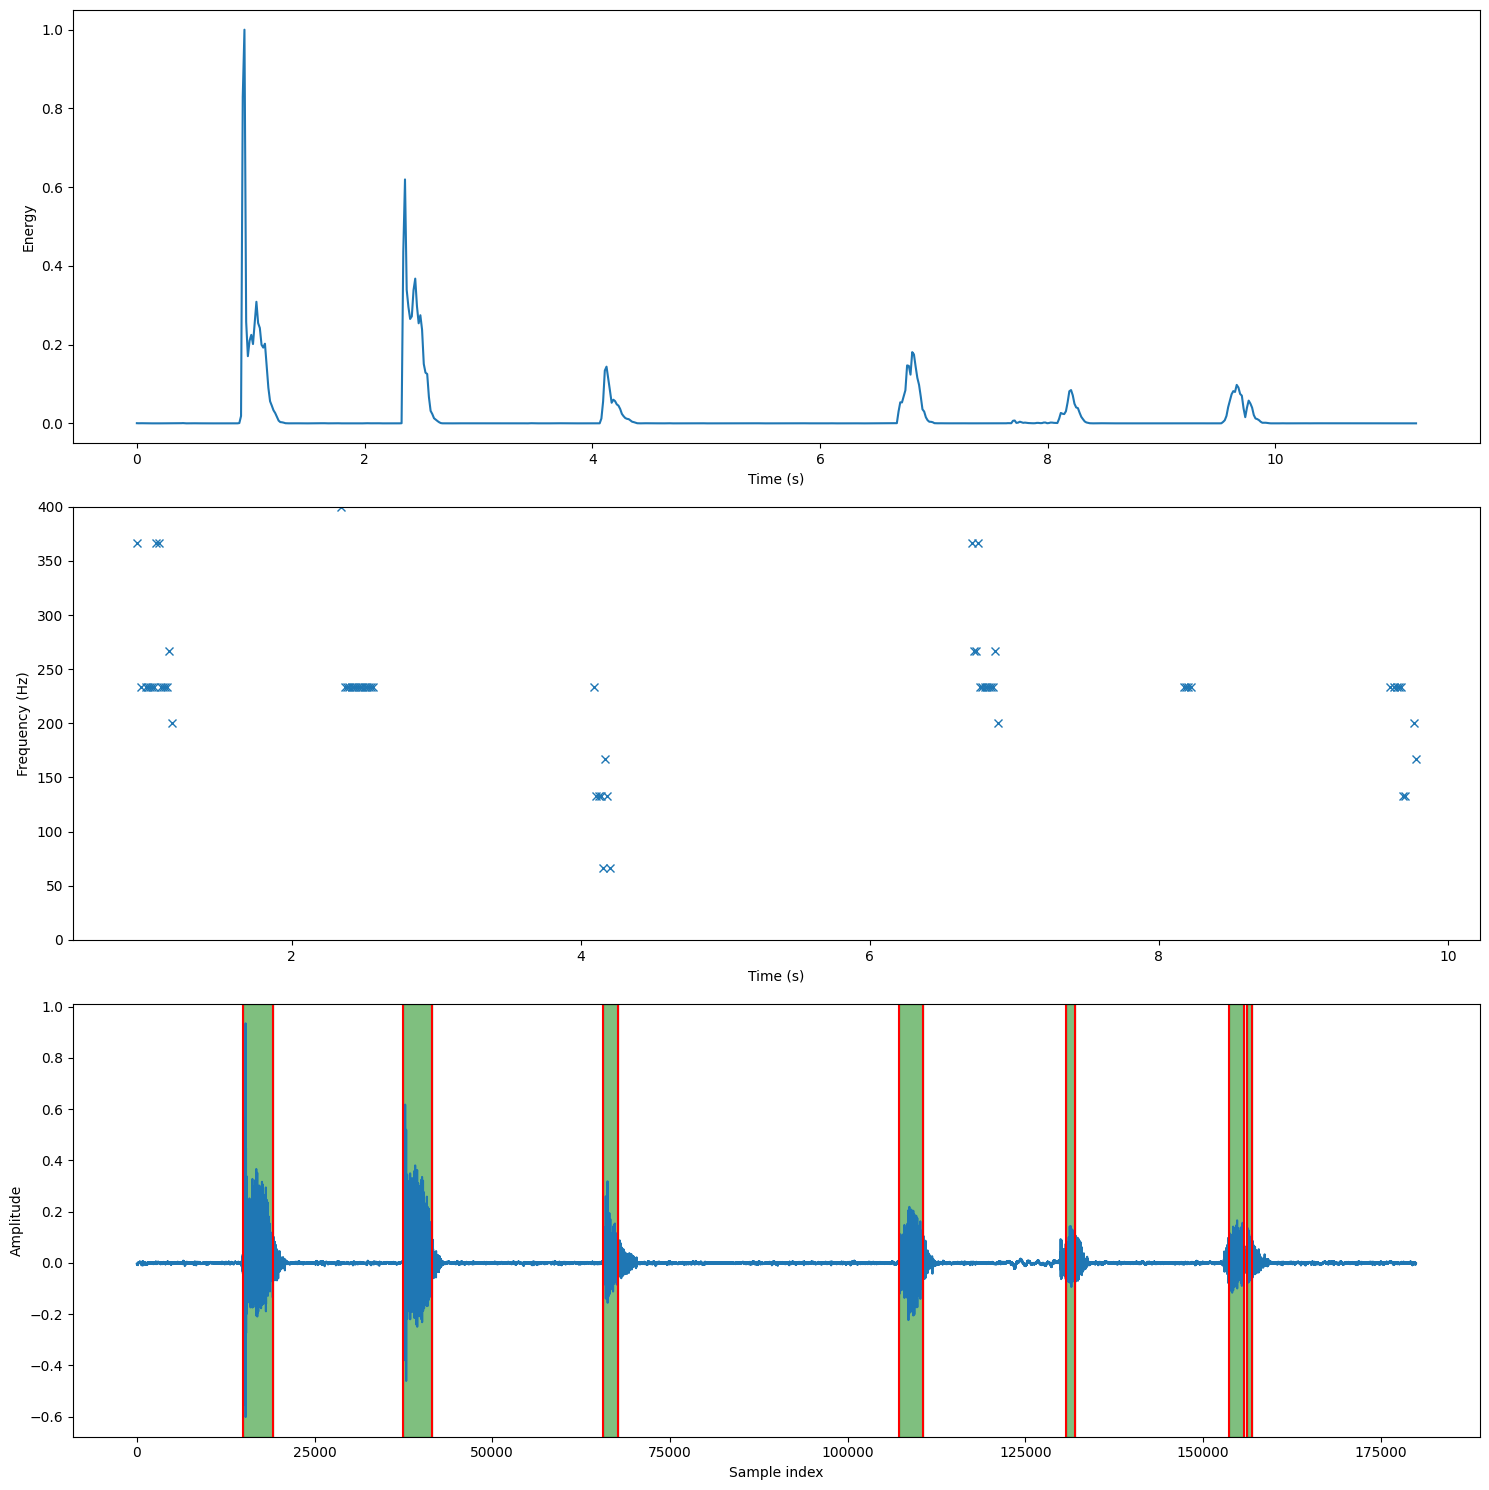

In [64]:
analize_audio('test_signals/lab_male.wav', 30, 0.05)

Frame length: 480, Hop length: 240
[(46, 66), (133, 156), (310, 333), (406, 424), (479, 486), (489, 490), (504, 505)]


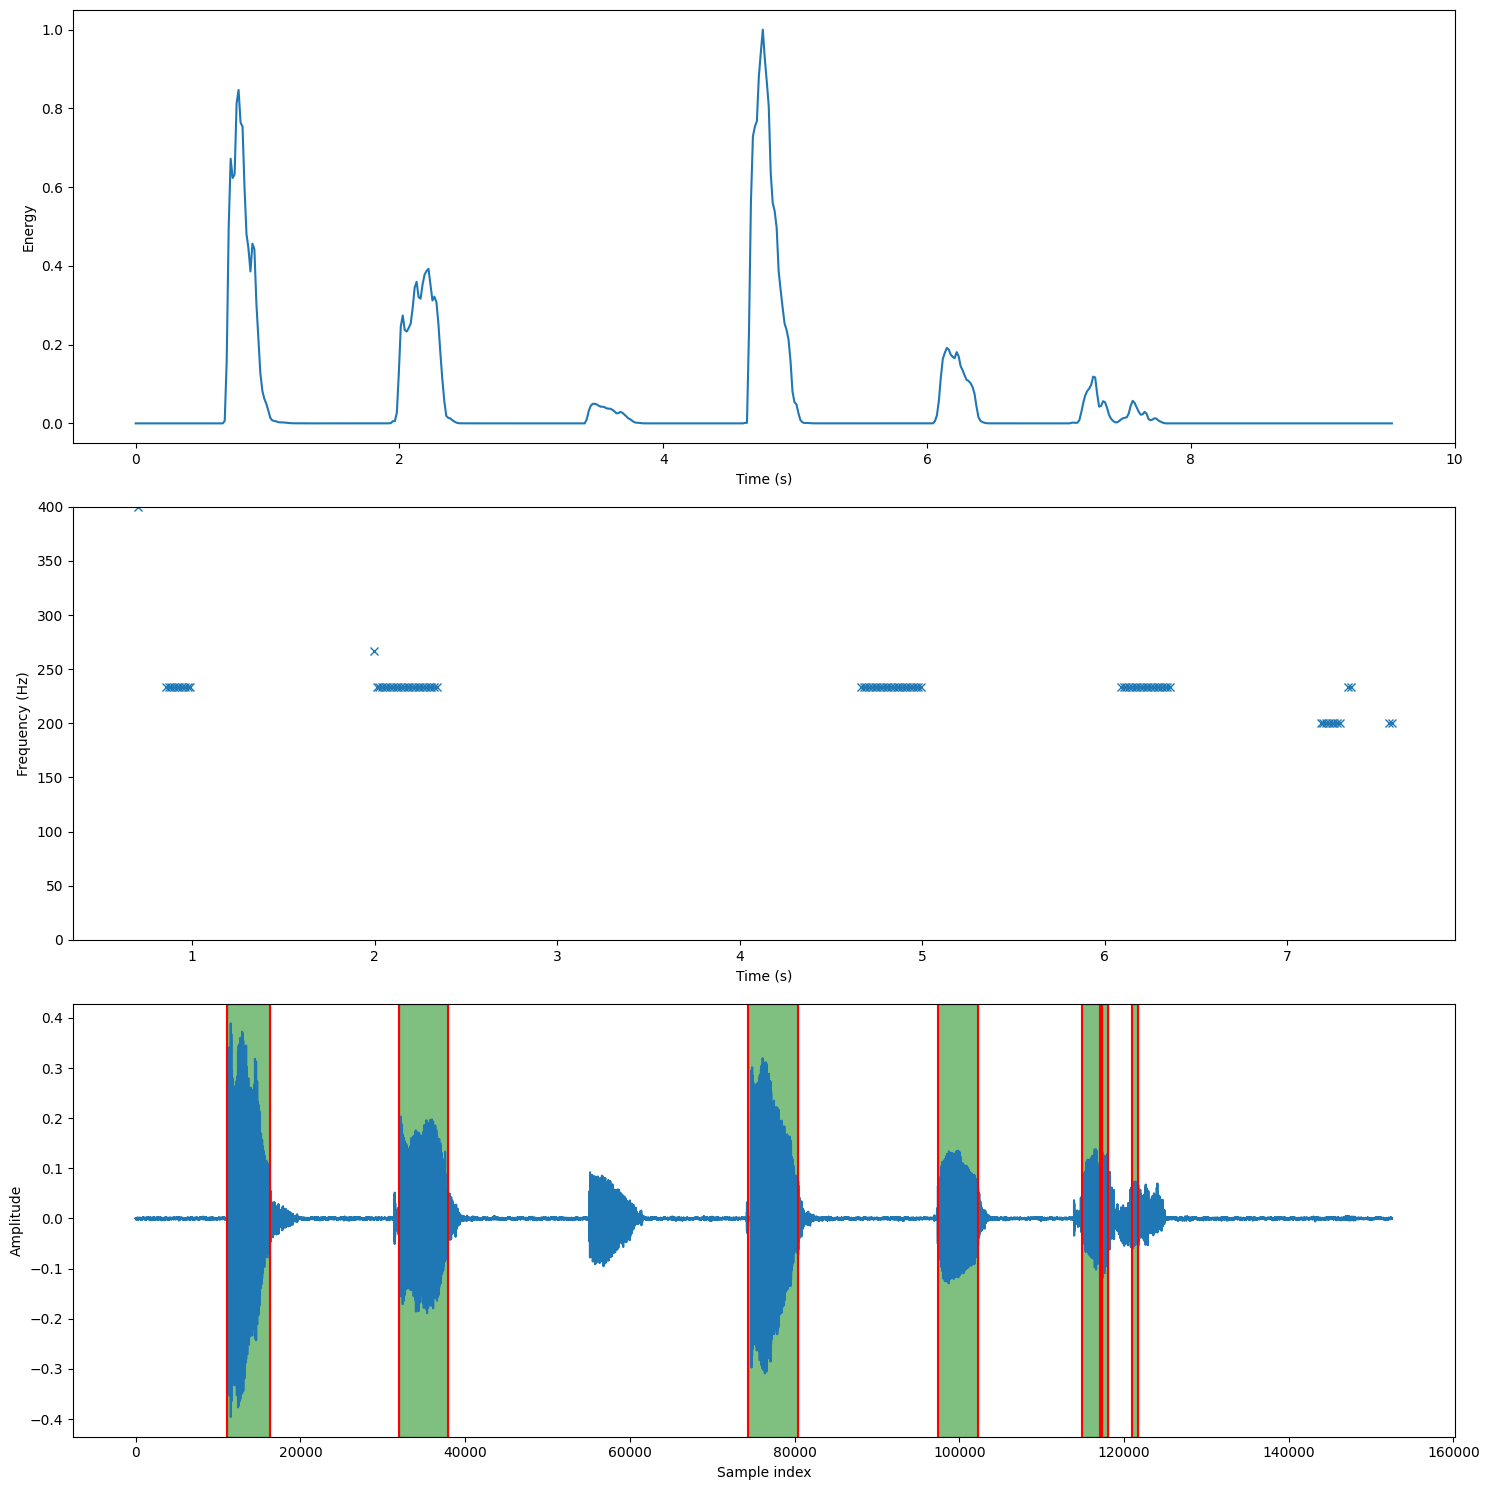

In [65]:
analize_audio('test_signals/lab_female.wav', 30, 0.05)

Frame length: 480, Hop length: 240
[(50, 57), (64, 70), (76, 80), (86, 96), (98, 107), (110, 116), (126, 147), (154, 161), (165, 172), (178, 185), (190, 194), (223, 232), (236, 242), (247, 253), (259, 262), (269, 294), (325, 332), (339, 344), (352, 377), (401, 411), (421, 441), (445, 451), (458, 462), (469, 480)]


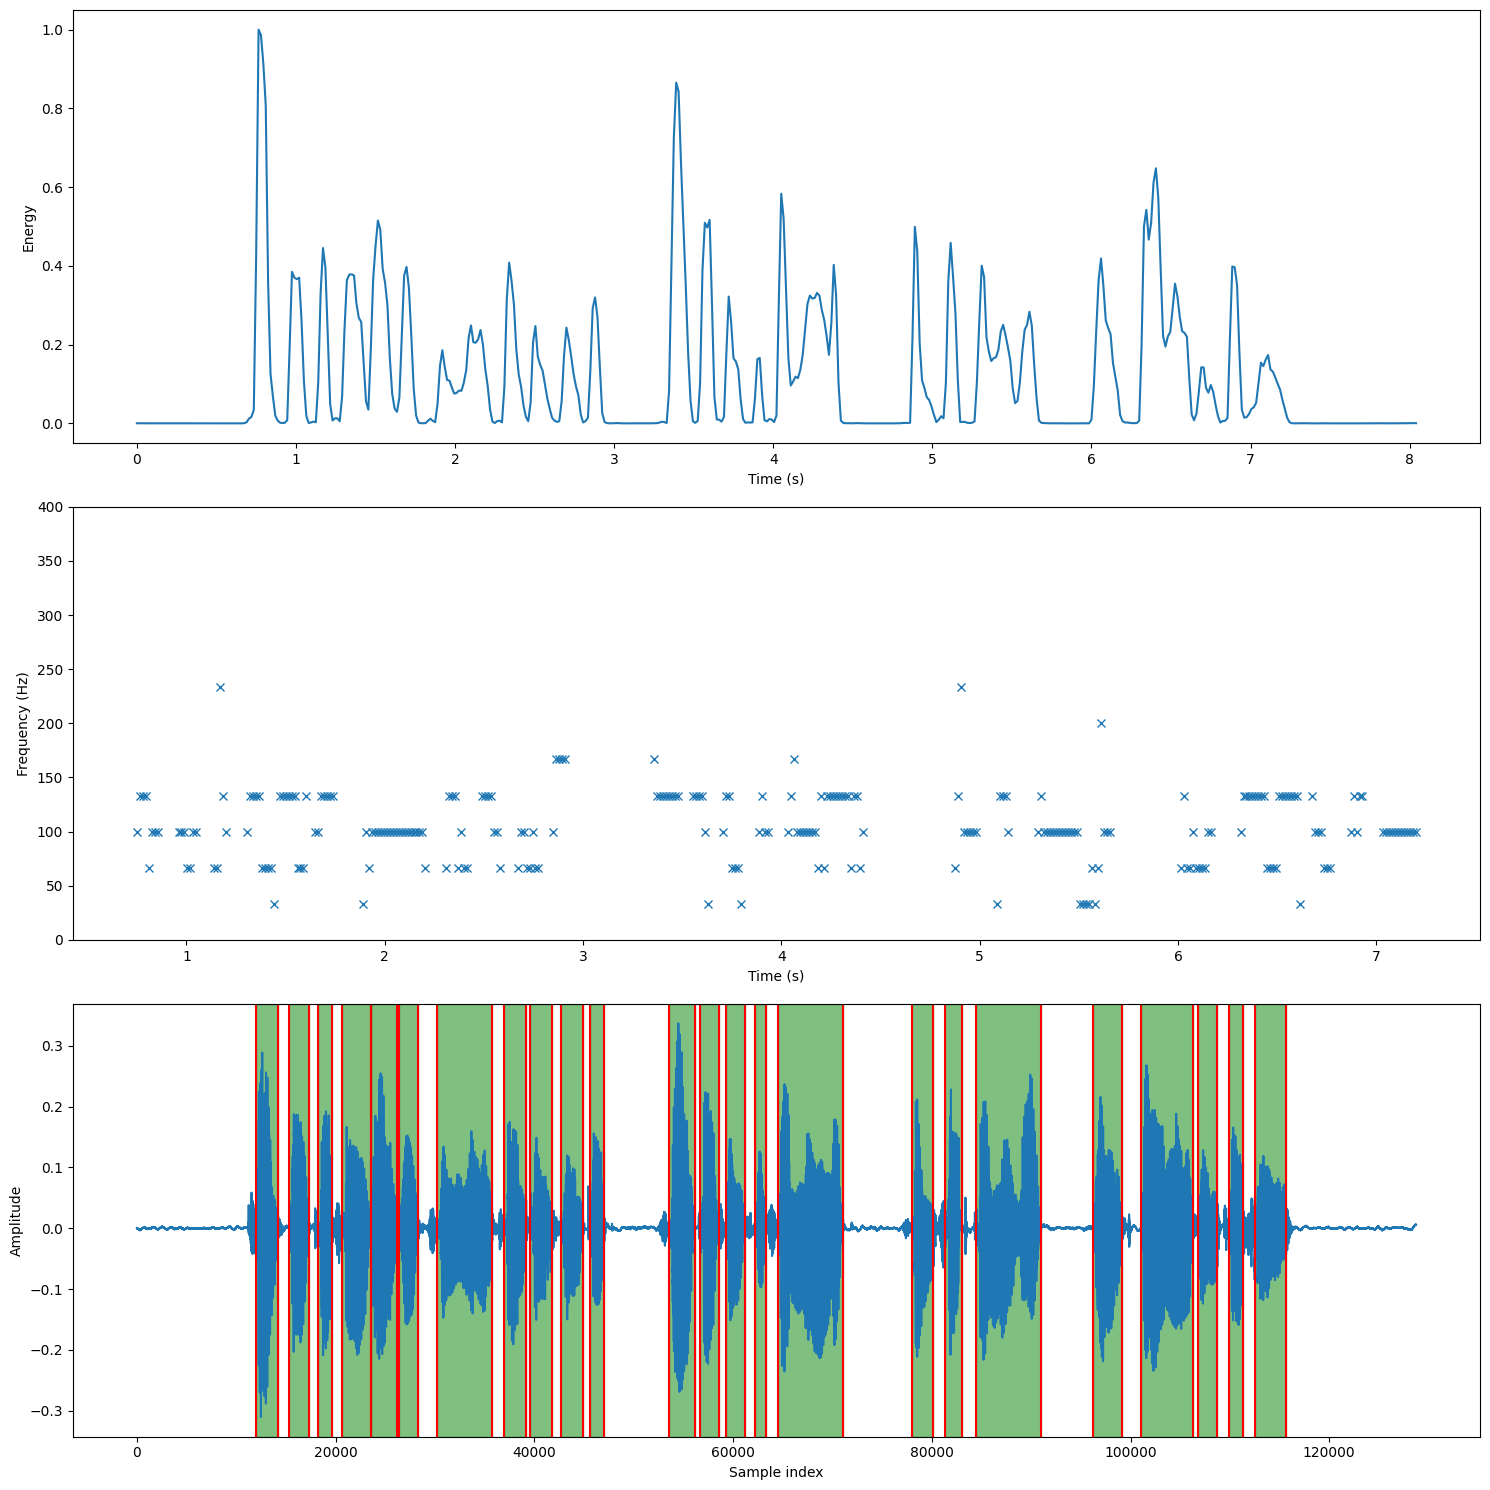

In [66]:
analize_audio('test_signals/studio_male.wav', 30, 0.05)

Frame length: 480, Hop length: 240
[(38, 44), (54, 65), (71, 86), (95, 102), (110, 115), (124, 140), (168, 182), (188, 202), (207, 209), (223, 234), (240, 243), (250, 258), (265, 279)]


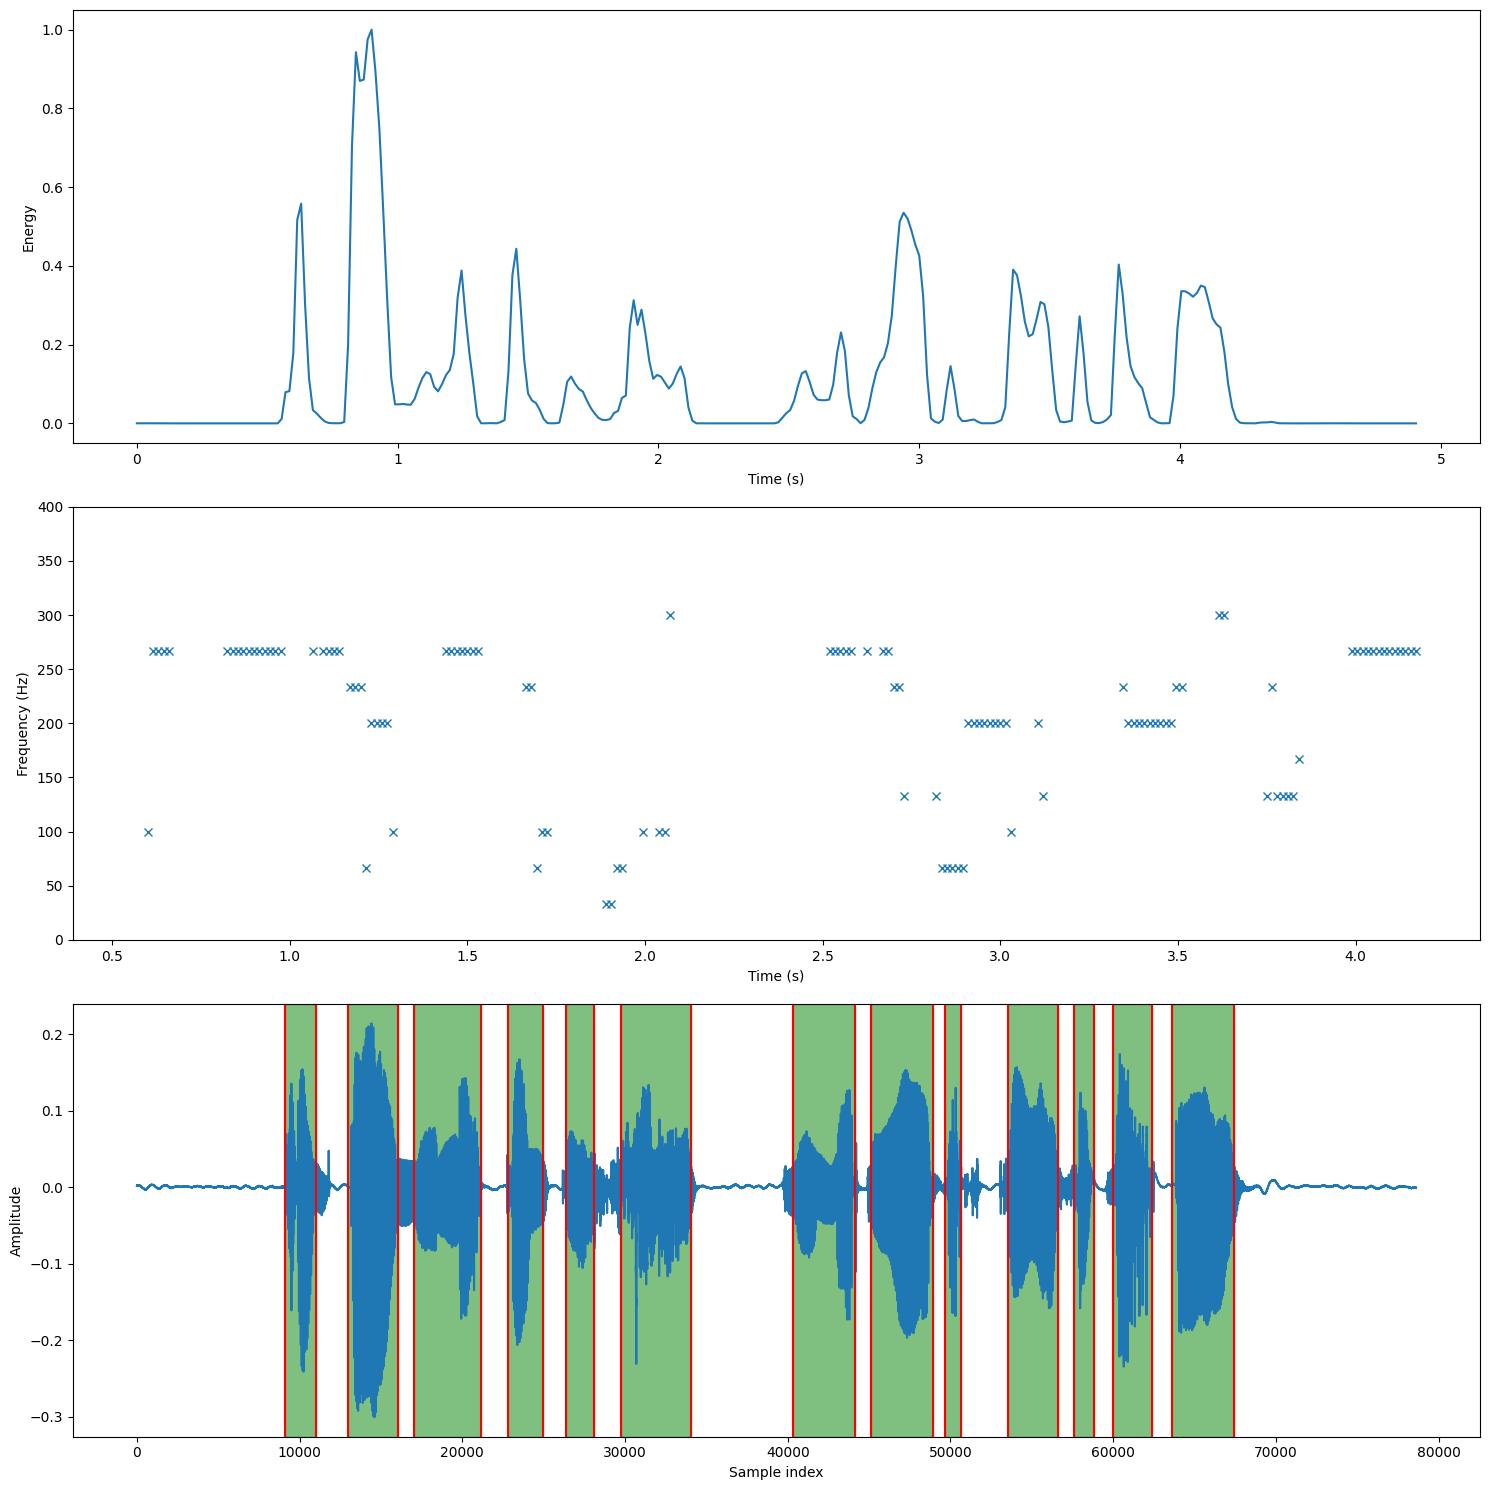

In [67]:
analize_audio('test_signals/studio_female.wav', 30, 0.05)

Frame length: 661, Hop length: 330
[(65, 70), (75, 83), (87, 108), (117, 123), (133, 153), (160, 178), (198, 238), (243, 248), (257, 267), (273, 295), (315, 322), (326, 336), (341, 347), (358, 370), (376, 387)]


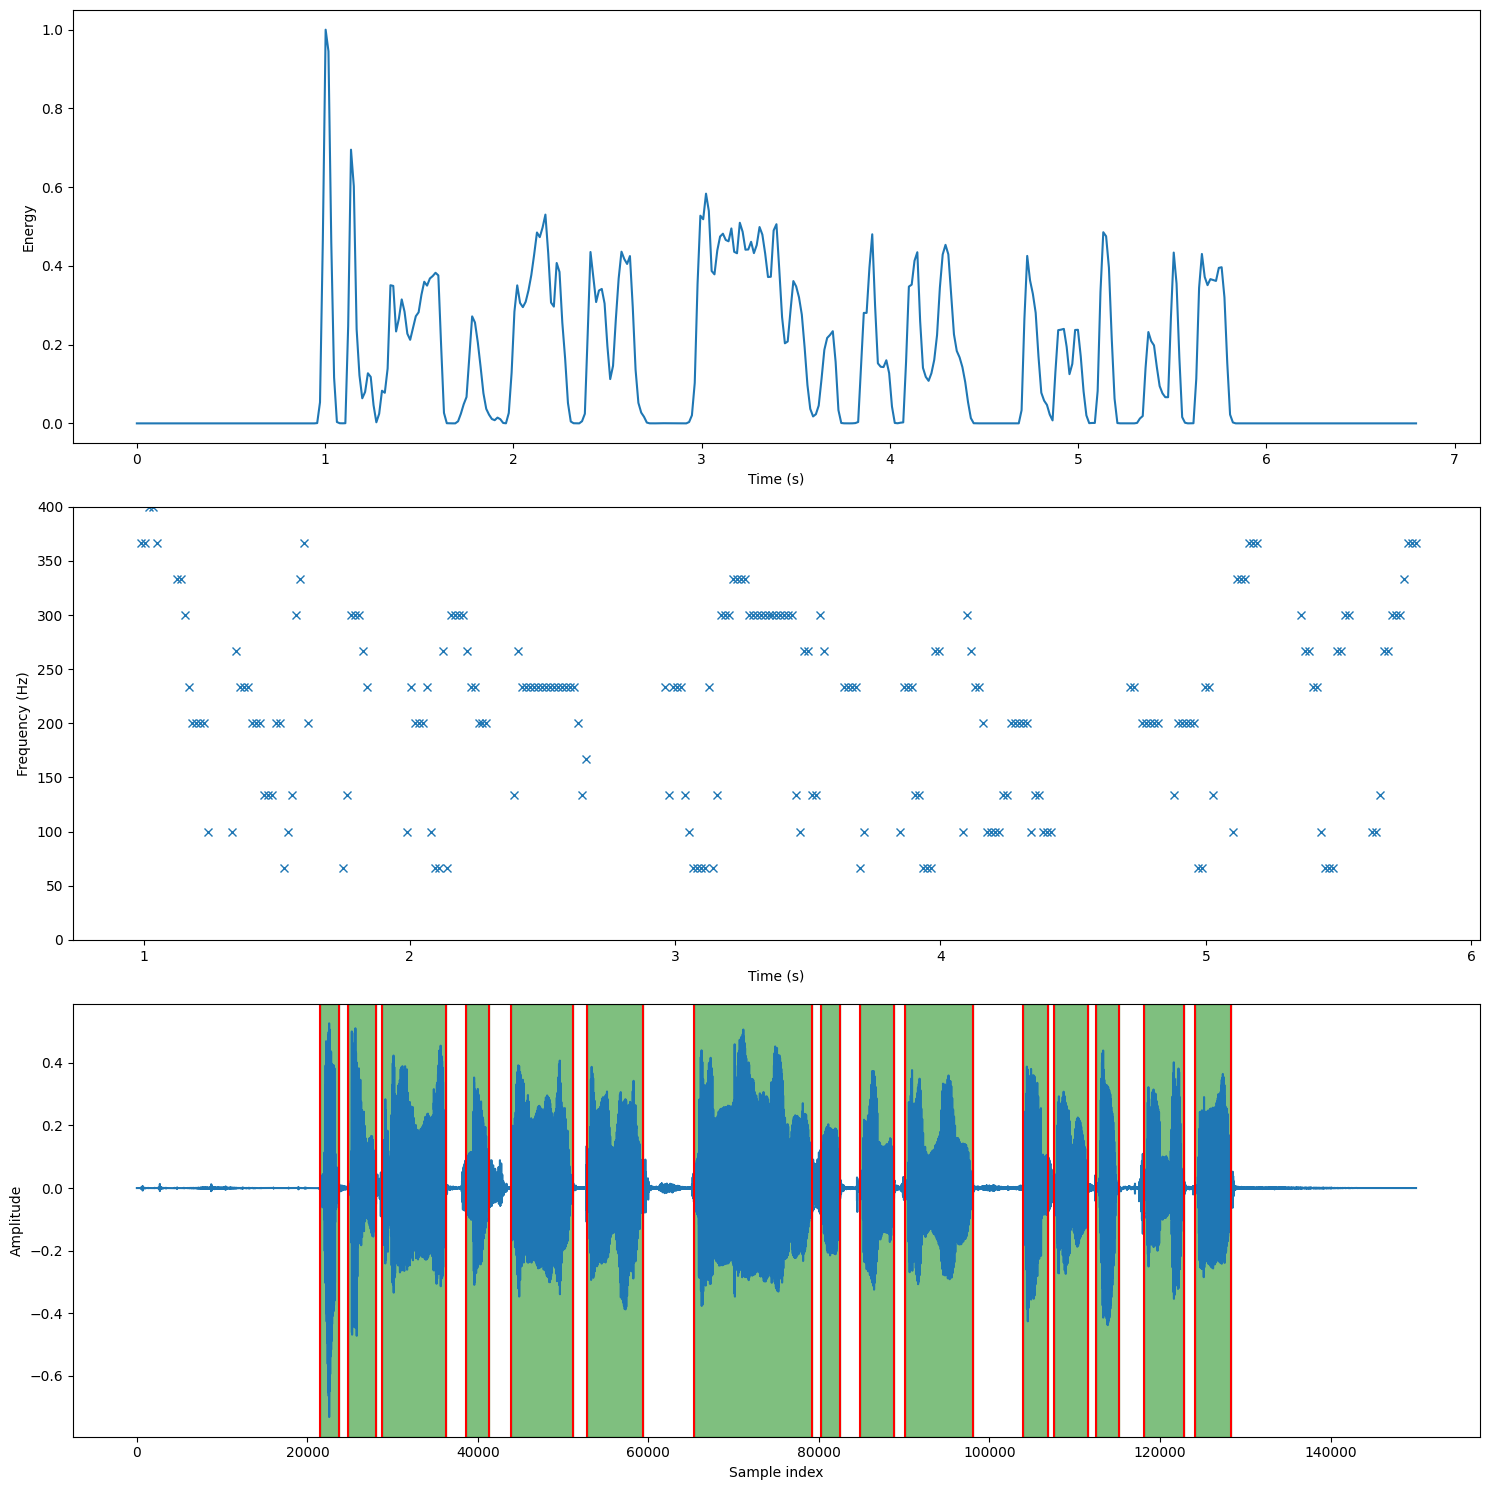

In [68]:
analize_audio('test_signals/FHU_RE_005.wav', 30, 0.05)

Frame length: 661, Hop length: 330
[(62, 78), (81, 113), (122, 144), (149, 169), (177, 222), (229, 234), (242, 249), (253, 274), (278, 294), (297, 304), (310, 339)]


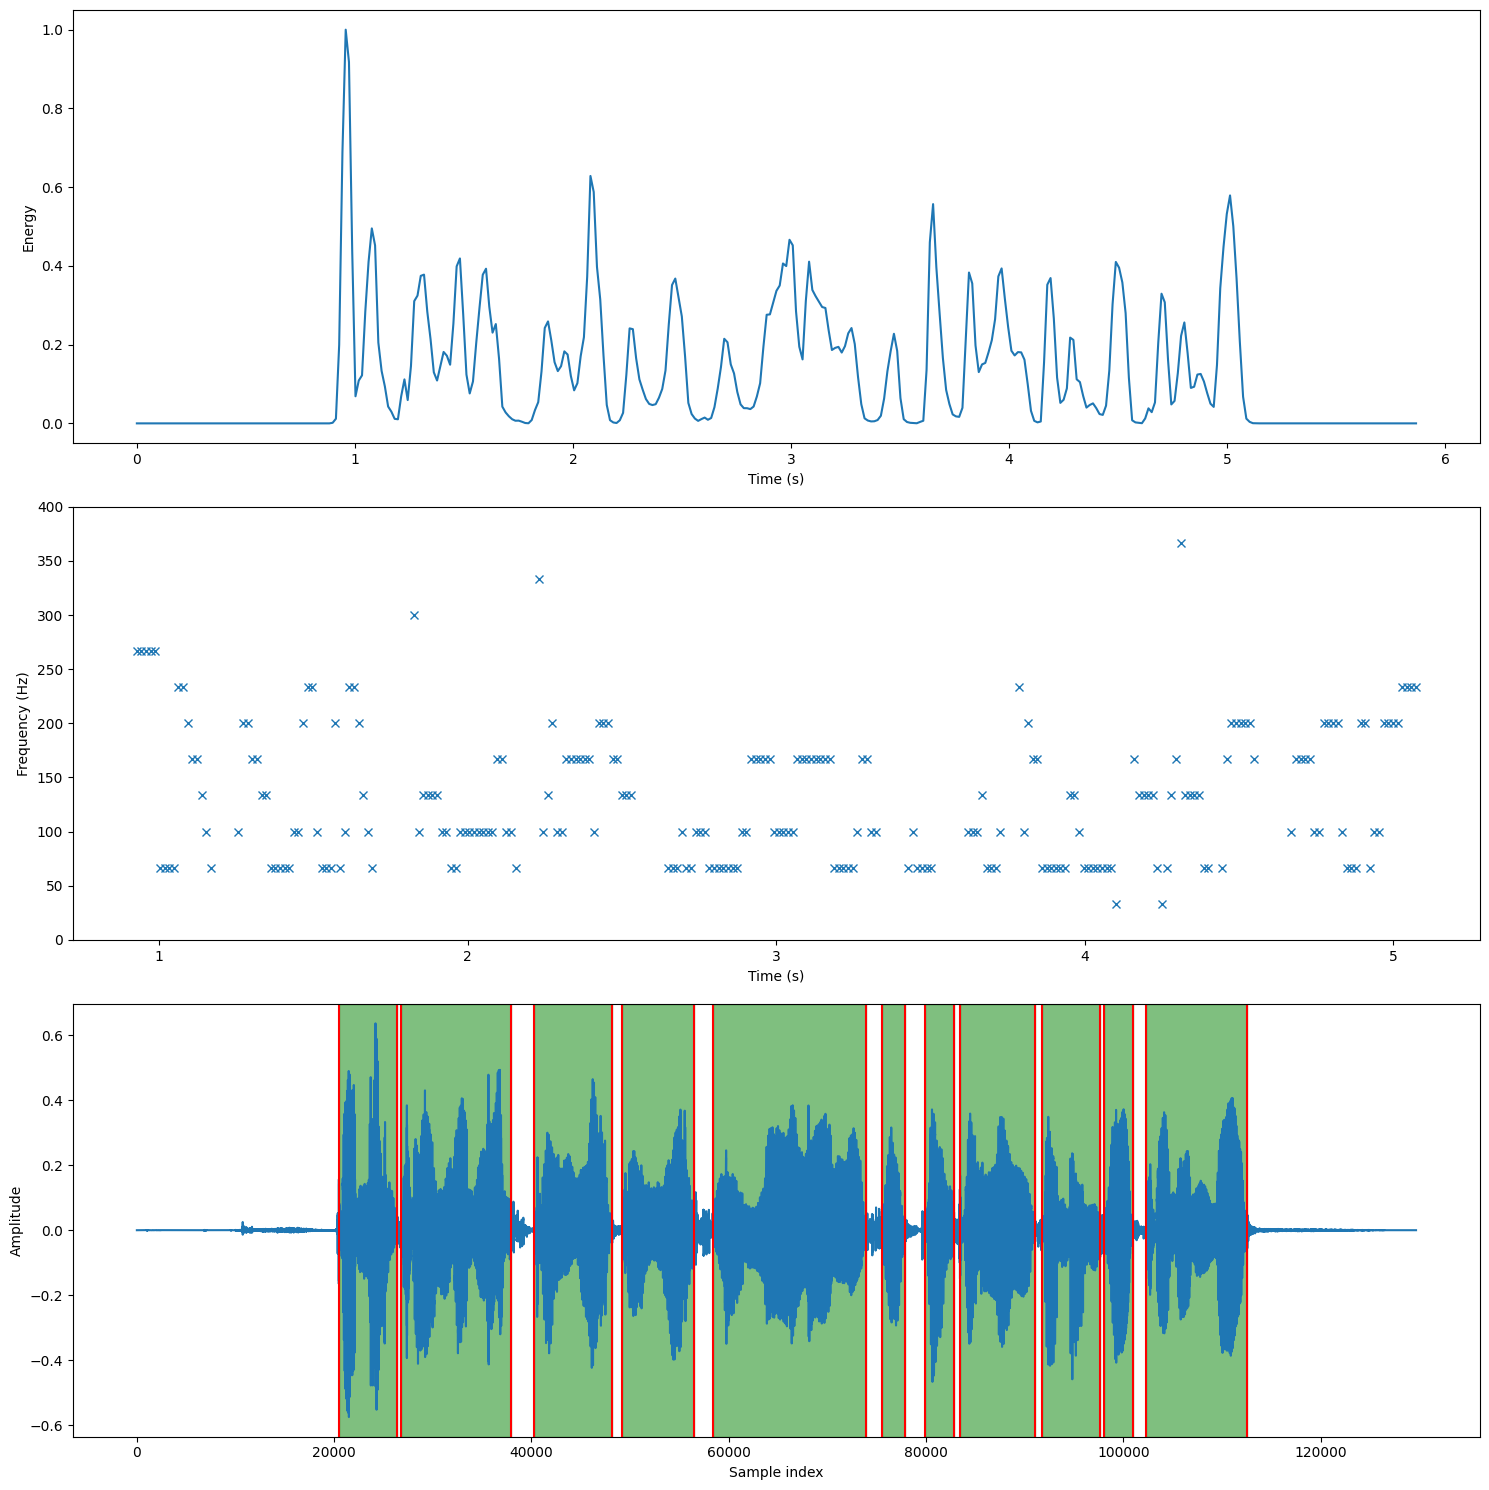

In [69]:
analize_audio('test_signals/MDU_RE_005.wav', 30, 0.025)

In [70]:
length_signal = librosa.get_duration(y=signal, sr=sampling_rate)
length_signal # độ dài tín hiệu

NameError: name 'signal' is not defined

In [1773]:
sampling_rate # tần số lấy mẫu

16000

In [1774]:
print(length_signal * sampling_rate) # số mẫu

128735.99999999999


In [1775]:
frame_length = int(0.03 * sampling_rate)
hop_length = frame_length // 2
def define_energy(signal: np.ndarray, frame_length, hop_length) -> np.ndarray:
    energy = np.array([
        sum(abs(signal[i:i+frame_length]**2))
        for i in range(0, len(signal), hop_length)
    ])

    return energy

def find_voice_index(signal: np.ndarray, frame_length, hop_length, thresh=0.05) -> list:
    index_voices = []

    # Tính energy
    energy = define_energy(signal, frame_length, hop_length)

    energy_norm = energy / max(energy)

    # Tạo danh sách các frame index mà energy >= ngưỡng
    for i in range(len(energy)):
        if energy_norm[i] >= thresh:
            index_voices.append(i)

    # Nếu không có frame nào thỏa mãn, trả về mảng trống
    if len(index_voices) == 0:
        return []

    # Tính các chỉ số sample tương ứng với các frame đầu và cuối hợp lệ
    start_sample_index = librosa.frames_to_samples(index_voices[0], hop_length=hop_length)
    end_sample_index = librosa.frames_to_samples(index_voices[-1] + 1, hop_length=hop_length)

    print(f"Start sample index: {start_sample_index}")
    print(f"End sample index: {end_sample_index}")

    # Trả về đoạn âm thanh sau khi loại bỏ các frame không hợp lệ
    return signal[start_sample_index:end_sample_index]

In [1776]:
signal_segment = find_voice_index(signal=signal, frame_length=frame_length, hop_length=hop_length, thresh=0.05)

Start sample index: 12000
End sample index: 115440


Text(0, 0.5, 'Amplitude')

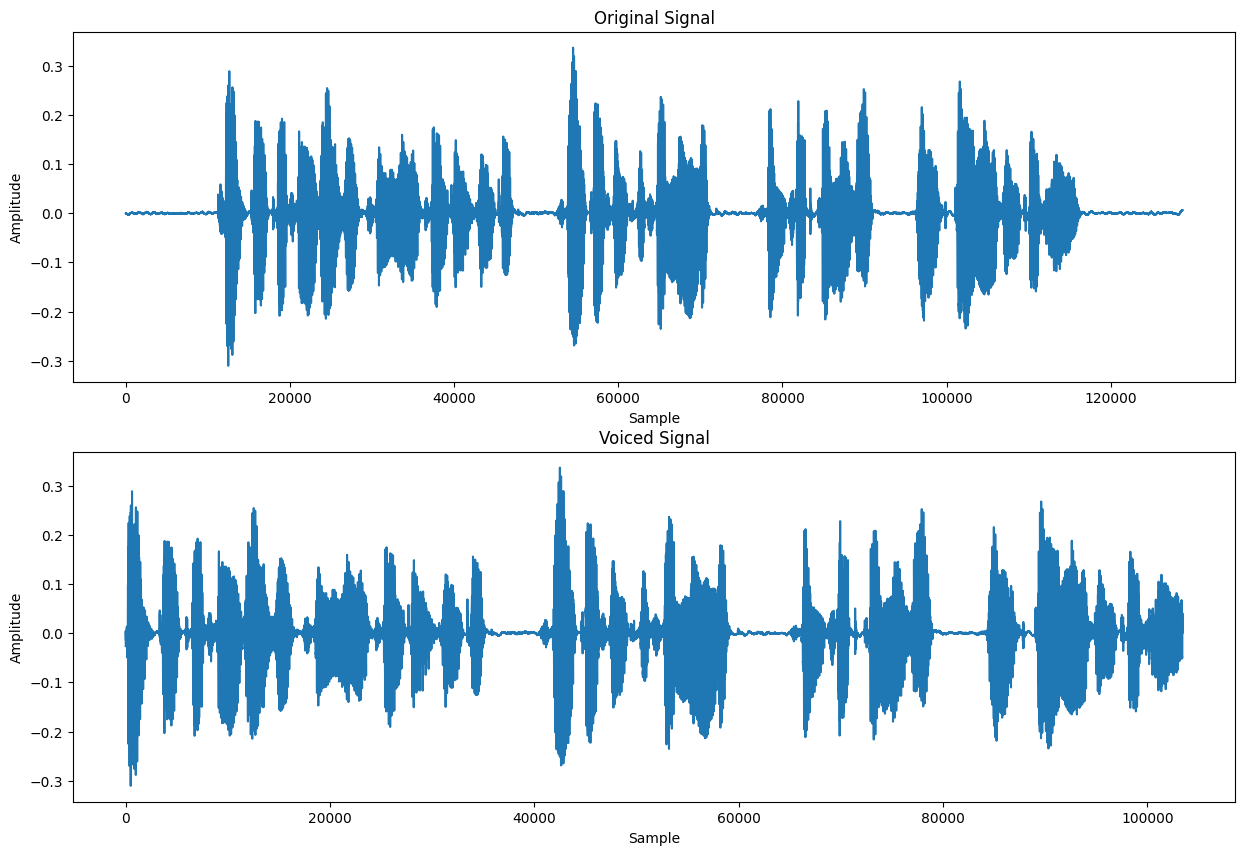

In [1777]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(signal)
plt.title('Original Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(signal_segment)
plt.title('Voiced Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

In [1778]:
N = len(signal) * 2 # độ dài (số mẫu) của tín hiệu âm thanh signal. N là số lượng điểm dữ liệu trong tín hiệu cần được xử lý.

T = 1.0 / sampling_rate # Khoảng thời gian giữa hai mẫu liên tiếp trong tín hiệu, hay còn gọi là chu kỳ lấy mẫu

window = np.hamming(len(signal)) # tạo ra một cửa sổ Hamming có cùng chiều dài với tín hiệu

yf = fft(signal * window) # chuyển tín hiệu từ miền thời gian sang miền tần số

xf = fftfreq(N, T)[:N//2] # tính toán các tần số này dựa trên số điểm mẫu N và chu kỳ lấy mẫu T.
# FFT là đối xứng chỉ cần lấy nửa đầu
# 0 - Nyquist Frequency 
amplitude_spectrum = 2.0 / N * np.abs(yf[:N//2]) # Do FFT trả về số phức, np.abs lấy giá trị mô-đun (độ lớn) của các giá trị này
#2.0 / N là một hệ số tỷ lệ để chuẩn hóa biên độ của các thành phần tần số.
# Nhân thêm 2.0 vì khi thực hiện FFT trên một tín hiệu thực, 
# nửa thứ hai của phổ là đối xứng, và chúng ta chỉ sử dụng nửa đầu phổ nên cần nhân hệ số 2 để bảo toàn năng lượng.

In [1779]:
# Đỉnh hài xuất hiện rõ ràng hơn ở tần số < 1kHz
max_freq = 1000
mask = xf < max_freq
xf = xf[mask]
amplitude_spectrum = amplitude_spectrum[mask]

In [1780]:
# Tính độ phân giải tần số
frequency_resolution = sampling_rate / N
print(f"Độ phân giải tần số: {frequency_resolution} Hz")

# Để tăng độ phân giải tần số (giảm khoảng cách giữa các tần số liên tiếp trong phổ Fourier),
# bạn cần tăng độ dài tín hiệu (số mẫu N) hoặc giảm tần số lấy mẫu (sampling rate).
# Tuy nhiên, giảm tần số lấy mẫu có thể làm mất thông tin về các tần số cao trong tín hiệu,
# do đó cách tốt nhất để tăng độ phân giải tần số thường là tăng độ dài tín hiệu.

Độ phân giải tần số: 0.06214267959234402 Hz


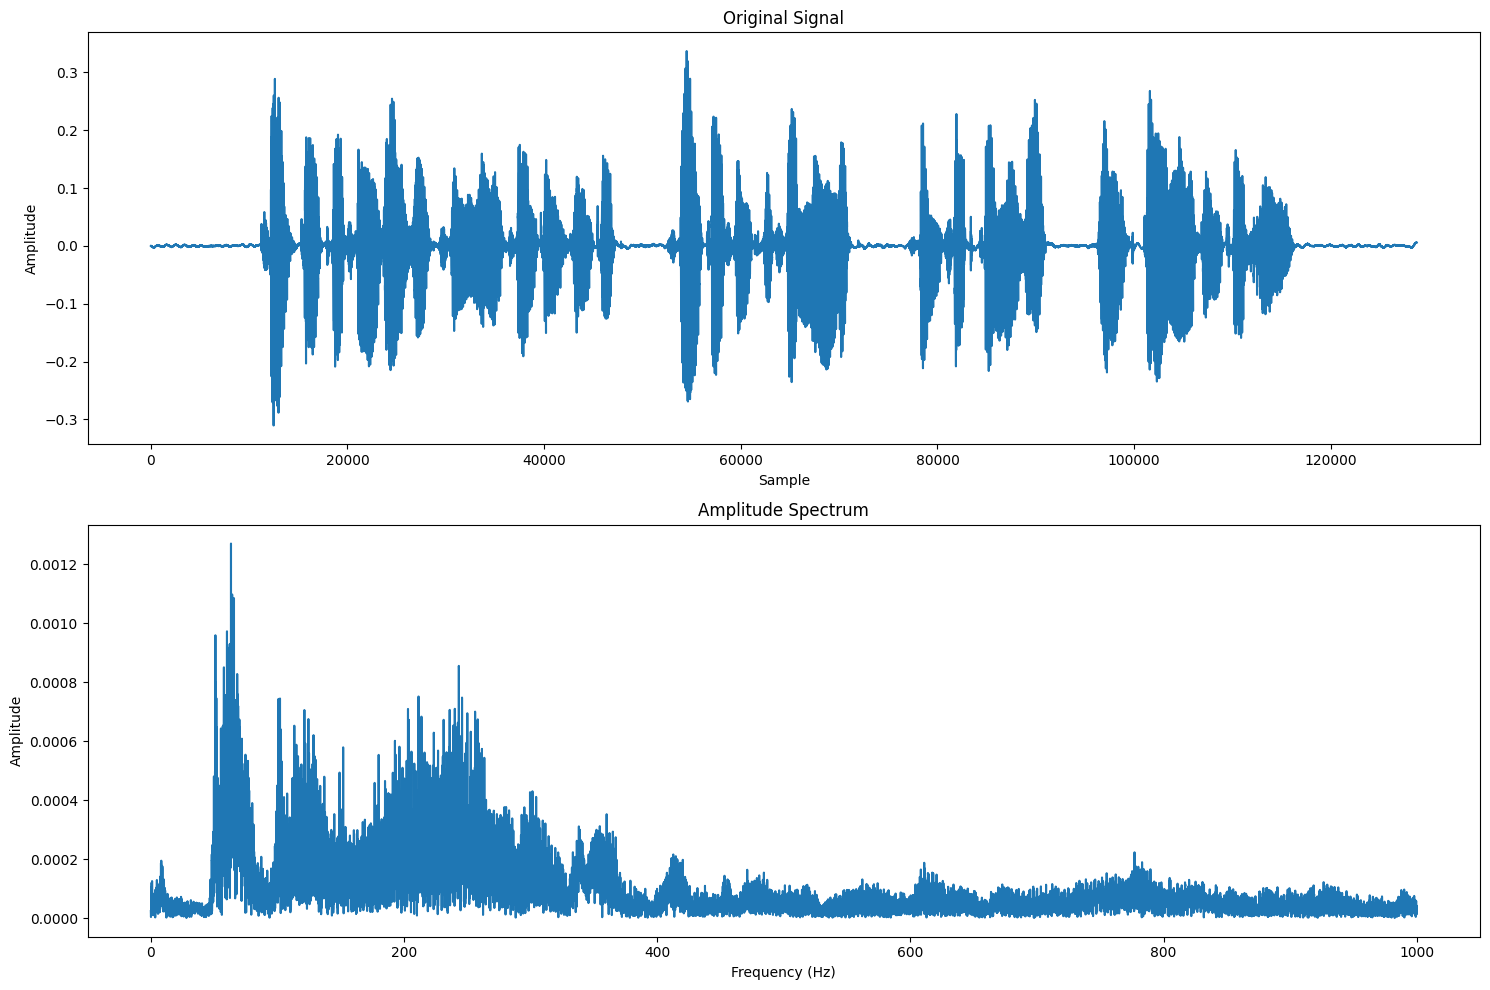

In [1781]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(signal)
plt.title('Original Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(xf, amplitude_spectrum) # 10 * np.log10(amplitude_spectrum) -> Log Amplitude
plt.title('Amplitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.tight_layout()